<a href="https://colab.research.google.com/github/arobiddin/data_scince_ls_works/blob/main/05_ml_05_amaliyot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Imgur](https://i.imgur.com/5pXzCIu.png)

# Data Science va Sun'iy Intellekt Praktikum

## 5-MODUL. Machine Learning

### Portfolio uchun vazifa: Toshkent shahrida uylarning narxini aniqlash.

Ushbu amaliyotda sizning vazifangiz berilgan ma`lumotlar asosida Toshkent shahridagi uylarning narxini aniqlash.

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import joblib

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
df.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65,1,4,49500
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70,3,5,55000


# Ustunlar ta'rifi
- `location` - sotilayotgan uy manzili
- `district` - uy joylashgan tuman
- `rooms` - xonalar soni
- `size` - uy maydoni (kv.m)
- `level` - uy

## Vazifani CRSIP-DM Metolodgiyasi yordamida bajaring.
<img src="https://i.imgur.com/dzZnnYi.png" alt="CRISP-DM" width="800"/>

# 1.Faoliyatni o'rganish.
1.1 Jarayonni o'rganamiz.
Berilgan ma`lumotlar asosida Toshkent shahridagi uylarning narxini aniqlash, ya'ni berilgan qilymatga yaqin qiymat topuvchi(bashorat qiluvchi) model tuzish.

1.2 Analitik yondashuv.
1)Supervised learning - sababi bizda ma'lumotlarda label (yorliq) mavjud. Bu hududdadi median narx. Biz ham aynan shu narxni bashorat qilmoqchimiz.
2)Regressiya - "Bashorat" (prognoz) dedikmi demak bu regressia algoritmlari yordamida hal qilinadi
3)Offline - sababi ma'lumotlar bizga avvaldan bir marta berilgan. Doimiy ma'lumotlar oqimi yo'q. Offline bajarish imkoni bor lekin qulaylik uchun online bajaryapman.

# Ma'lumotlarni o'rganish

In [4]:
sum(df.duplicated())

700

In [5]:
df = df.drop_duplicates() # Takrorlangan qiymatlarni o'chirib tashlaymiz.


In [6]:
dfx = df[df['price']=='Договорная'].index   # Nostandart qiymatlarni ham o'chirib tashlaymiz.
df.drop(dfx, inplace=True)

In [7]:
df['price'] = df['price'].astype(str).astype(int)


In [8]:
df[df['size']=='Площадьземли:1сот']['size']  # Ma'lumotlarni standart holatga keltiramiz
df.loc[5347, 'size']=100
df['size'] = df['size'].astype(str).astype(float)

In [12]:
# Grafik analizdan ayon bo'ldiki yuqori qiymatli uylar modelni yaratishga imkon yaratmaydi ekan.
df = df[(df['size']>10) & (df['size']<120) & (df['price']>4000) & (df['price']<=115_000) & (df['max_levels']<15)  & (df['level']<10) & (df['rooms']<6)]

In [10]:
# Uylarni baholashda asosan tumanlarga e'tibor qaratildi chunki ma'lumotlar oz. Ma'lumotlar ko'paygan sari uy manzillari bilan ishlash ehtiyoji ko'payadi.  
df = df.drop('location', axis=1)
df.head()

,district,rooms,size,level,max_levels,price
0,Юнусабадский,3,57.0,4,4,52000
1,Яккасарайский,2,52.0,4,5,56000
2,Чиланзарский,2,42.0,4,4,37000
3,Чиланзарский,3,65.0,1,4,49500
4,Чиланзарский,3,70.0,3,5,55000


In [15]:
df[(df['rooms']==3) & (df['size']<30)]

,district,rooms,size,level,max_levels,price


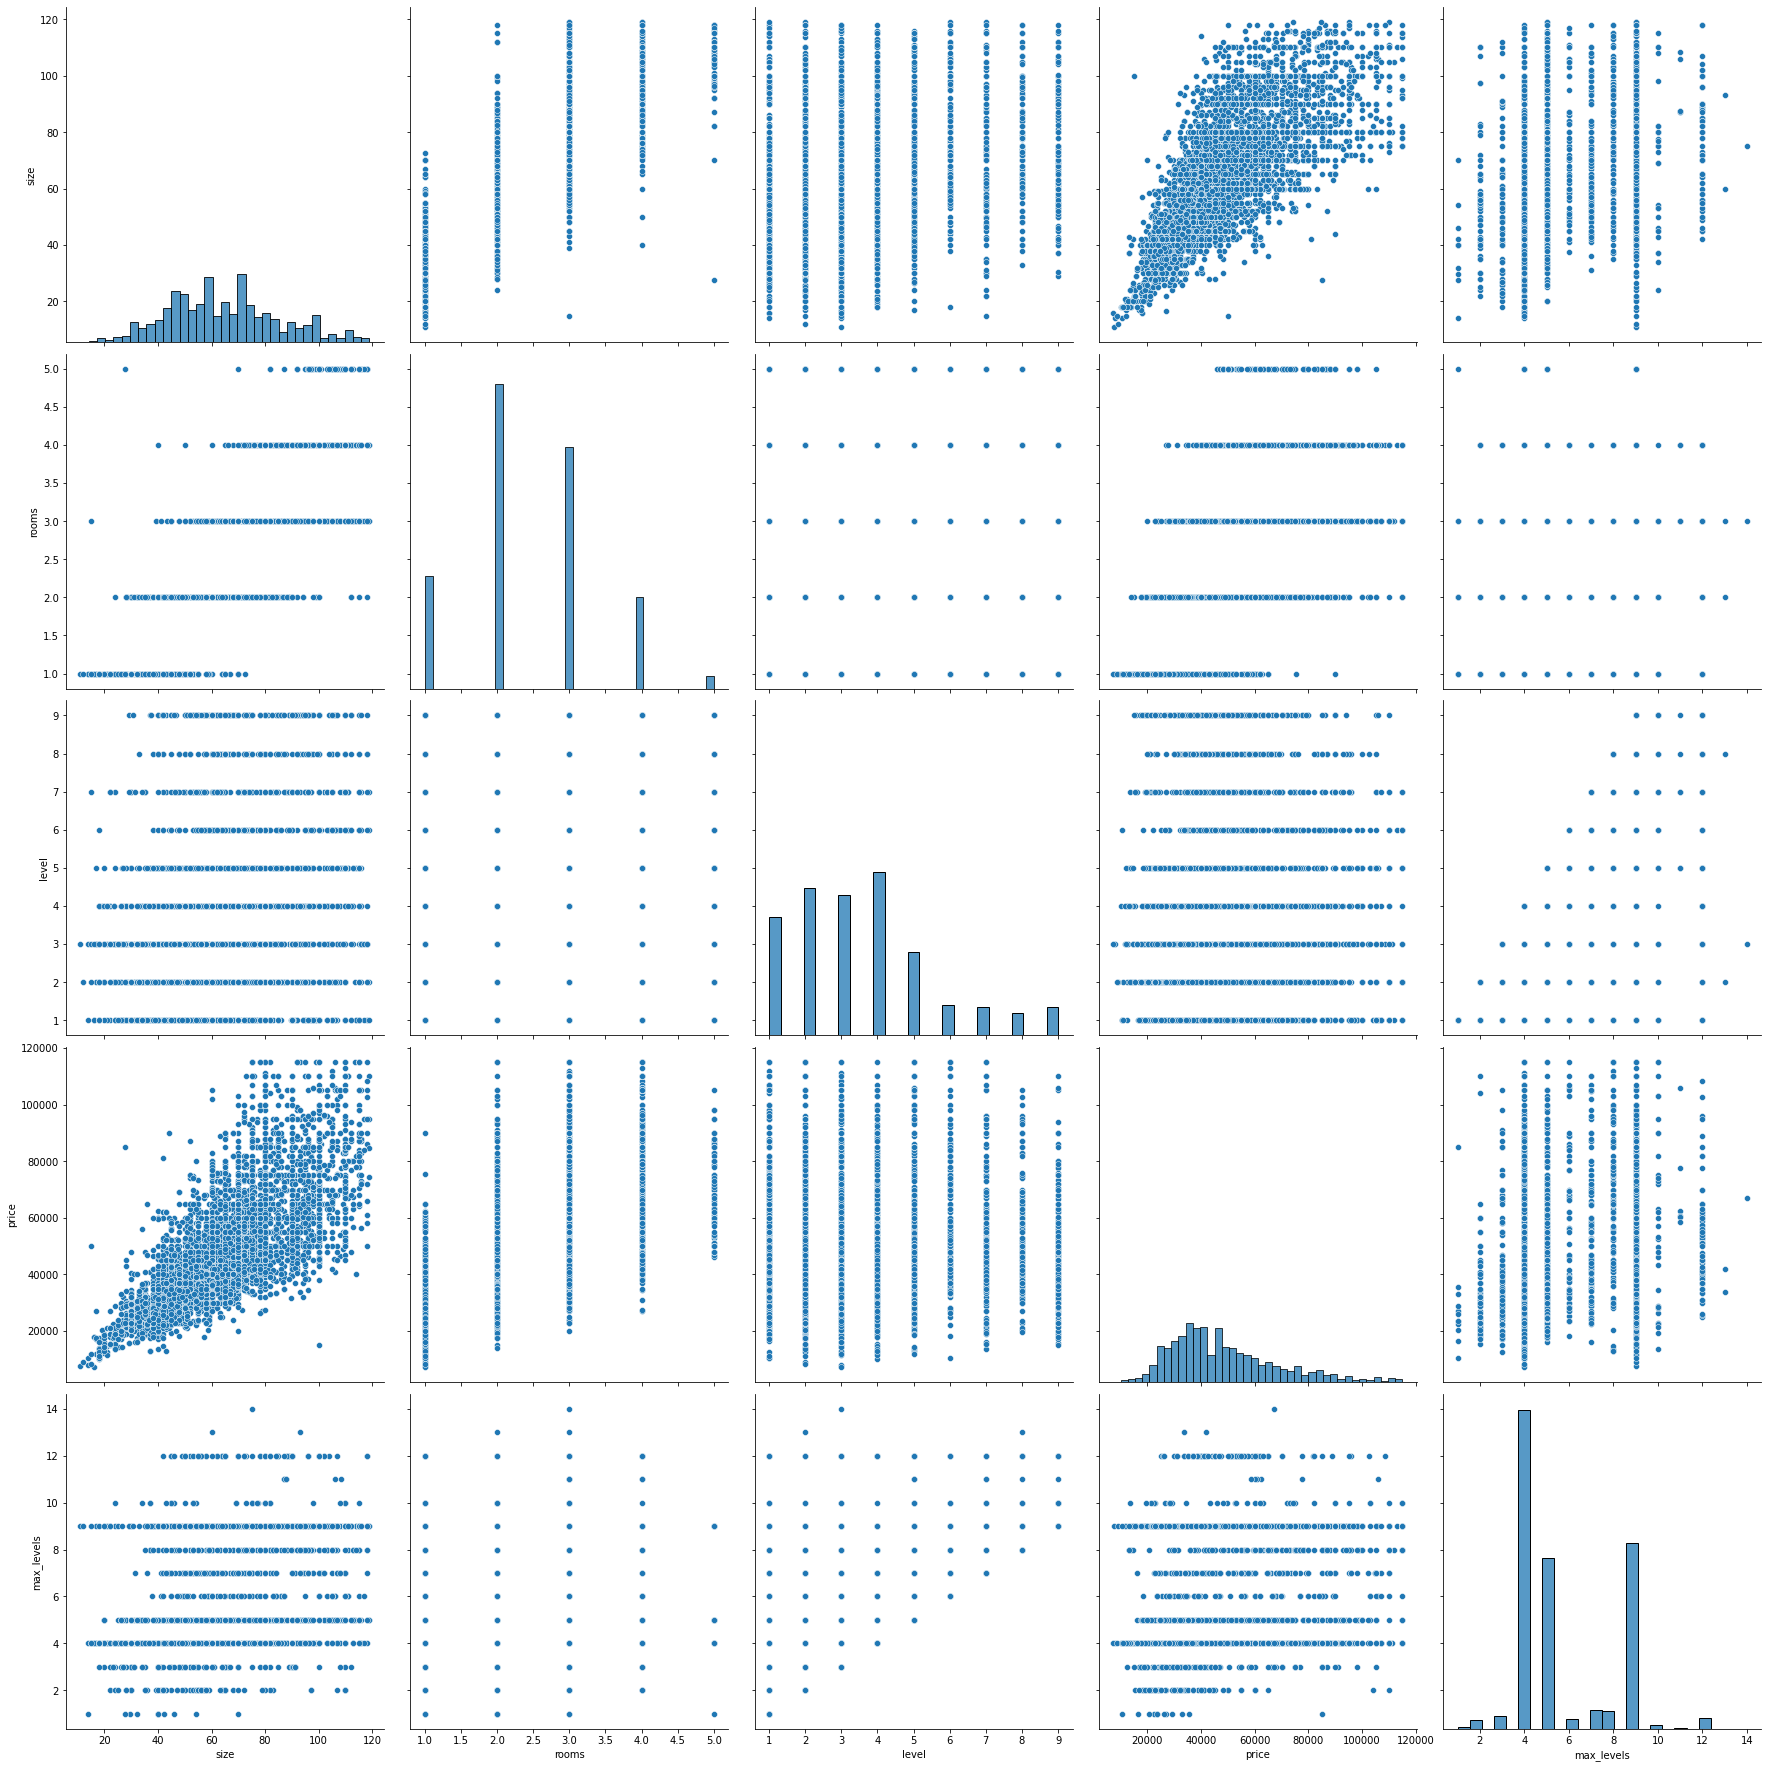

In [13]:
cols = ['size','rooms','level','price','max_levels']  #,'max_levels'
sns.pairplot(df[cols], height=5)
plt.show()

In [14]:
indx = [6055, 2794,  2104, 1042, 7407, 5613, 2591, 4462]
df.drop(index=indx, inplace=True)

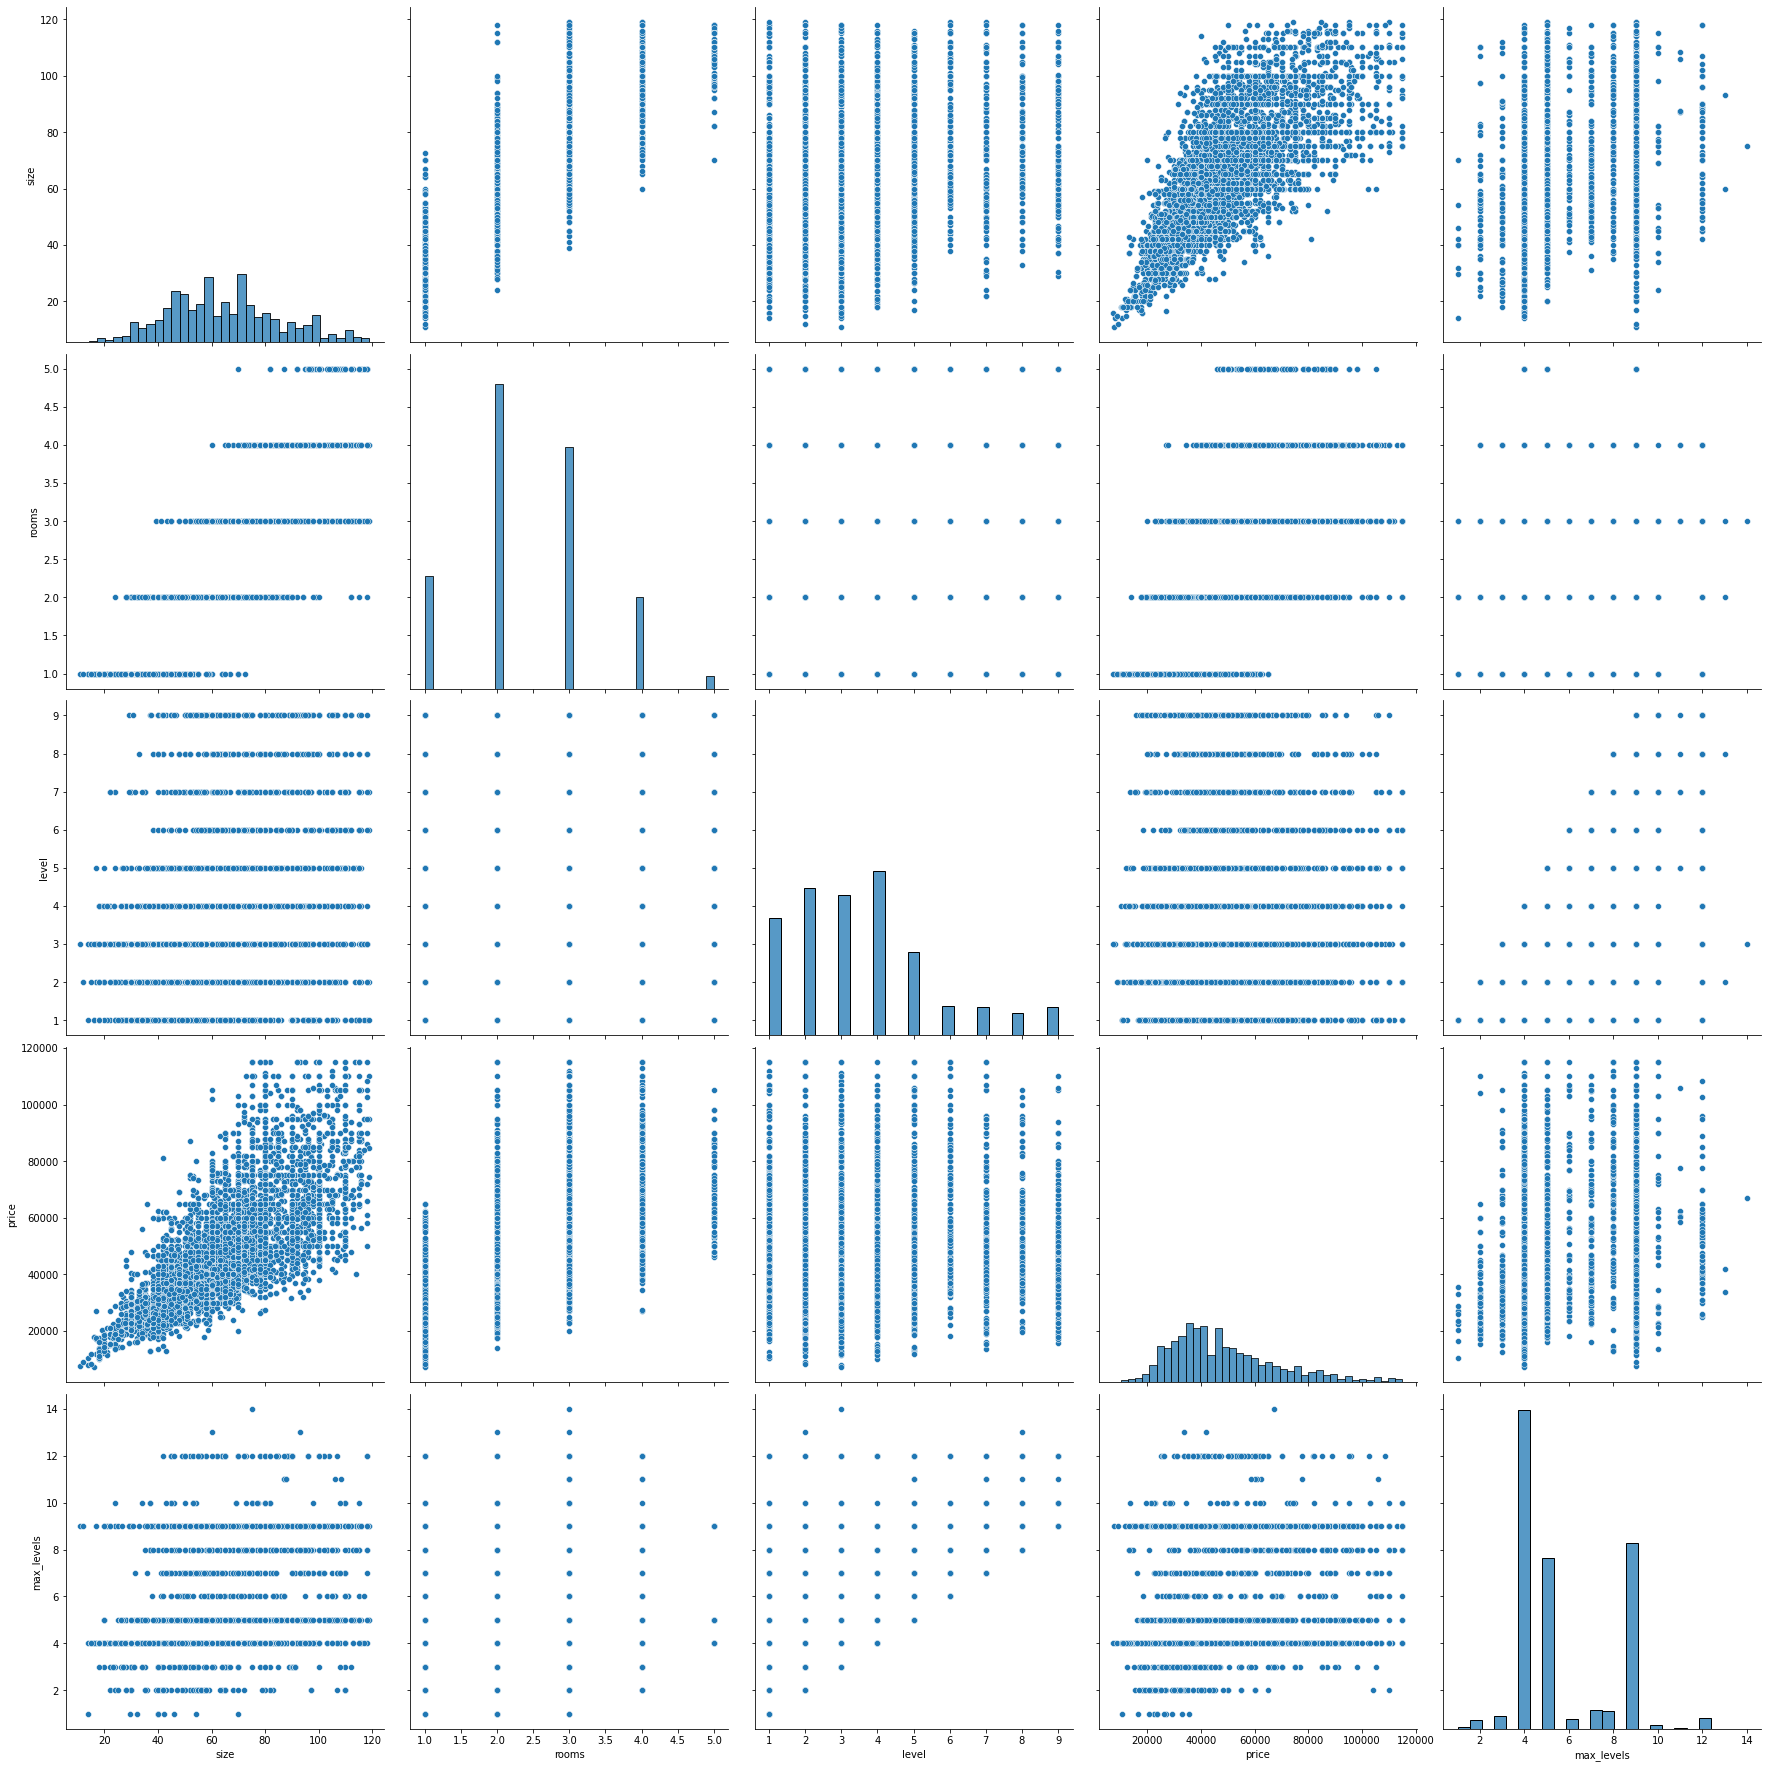

In [16]:
cols = ['size','rooms','level','price','max_levels']  #,'max_levels'
sns.pairplot(df[cols], height=5)
plt.show()

In [17]:
df.describe()

,rooms,size,level,max_levels,price
count,5953.000000,5953.000000,5953.000000,5953.000000,5953.000000
mean,2.457080,64.506639,3.569965,5.752898,48212.146481
std,0.938399,20.709683,2.041534,2.273456,19879.890779
min,1.000000,11.000000,1.000000,1.000000,7300.000000
25%,2.000000,50.000000,2.000000,4.000000,34000.000000
50%,2.000000,63.000000,3.000000,5.000000,44000.000000
75%,3.000000,78.000000,5.000000,9.000000,59000.000000
max,5.000000,119.000000,9.000000,14.000000,115000.000000


In [19]:
df.corrwith(df['price']).sort_values(ascending=False)

price         1.000000
size          0.743932
rooms         0.611974
max_levels    0.259226
level         0.088800
dtype: float64

## 3. Ma'lumotlarni Machine Learning uchun tayyorlash

## Ma'lumotlarni train & testga ajratamiz

In [21]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=71)

X_train = train_set.drop("price", axis=1)
y = train_set["price"].copy()

X_num = X_train.drop('district', axis=1)
X_num

,rooms,size,level,max_levels
5224,3,65.0,3,4
7017,1,43.0,3,9
2019,2,43.0,4,4
123,3,70.0,2,4
610,2,43.0,4,4
...,...,...,...,...
1529,3,75.0,7,9
1848,3,105.0,1,8
6565,4,80.0,1,4
3756,2,60.0,1,4


## Pipeline quramiz

In [22]:
# bizga kerak ustunlar indekslari
rooms_ix,	size_ix,	max_level_ix,	= 0, 1, 3

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_SLR = True):
        self.add_SLR = add_SLR
    def fit(self, X, y=None):
        return self # bizni funksiyamiz faqat transformer. estimator emas
    def transform(self, X):
        size_room = X[:, size_ix] / X[:, rooms_ix] 
        if self.add_SLR: # price_level ustuni ixtiyoriy bo'ladi
            size_level = X[:, size_ix] / X[:, max_level_ix] 
            return np.c_[X, size_room, size_level] 
        else:
            return np.c_[X, size_room] 


## Sonli ustunlar uchun 

In [23]:
num_pipeline = Pipeline([
          ('imputer', SimpleImputer(strategy='median')),
          ('attribs_adder', CombinedAttributesAdder(add_SLR = True)),
          ('std_scaler', StandardScaler())             
])

## Matnli ustunlar uchun va full Pipeline

In [24]:
num_attribs = list(X_num)
cat_attribs = ['district']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OrdinalEncoder(), cat_attribs)
])

In [25]:
X_prepared = full_pipeline.fit_transform(X_train)

In [26]:
X_prepared[0:5,:]

array([[ 0.58379329,  0.02898914, -0.28247376, -0.77362277, -0.91693381,
         0.71900828,  6.        ],
       [-1.55140152, -1.03709896, -0.28247376,  1.42498766,  2.36621224,
        -1.4177122 ,  3.        ],
       [-0.48380412, -1.03709896,  0.20881187, -0.77362277, -0.94258339,
        -0.30537588,  1.        ],
       [ 0.58379329,  0.27128189, -0.77375938, -0.77362277, -0.66043803,
         0.95182286,  9.        ],
       [-0.48380412, -1.03709896,  0.20881187, -0.77362277, -0.94258339,
        -0.30537588,  2.        ]])

## Machine Learning

In [30]:
LR_model = LinearRegression()

In [32]:
LR_model.fit(X_prepared, y)

LinearRegression()

## Modelni baholaymiz

In [33]:
# tasodifiy 5 ta qatorni ajratib olamiz
test_data = X_train.sample(5)
test_data

,district,rooms,size,level,max_levels
2644,Яшнободский,3,93.0,3,4
879,Яккасарайский,3,85.0,2,4
6318,Чиланзарский,3,70.0,3,5
5604,Чиланзарский,1,30.0,1,4
6773,Шайхантахурский,2,58.0,2,4


In [34]:
test_label = y.loc[test_data.index]
test_label

2644     57000
879     110000
6318     51500
5604     26500
6773     47500
Name: price, dtype: int64

In [35]:
test_data_prepared = full_pipeline.transform(test_data)
test_data_prepared

array([[ 0.58379329,  1.38582855, -0.28247376, -0.77362277,  0.51944258,
         2.02276992, 11.        ],
       [ 0.58379329,  0.99816015, -0.77375938, -0.77362277,  0.10904933,
         1.6502666 ,  9.        ],
       [ 0.58379329,  0.27128189, -0.28247376, -0.33390068, -0.66043803,
         0.29994203,  6.        ],
       [-1.55140152, -1.66706012, -1.26504501, -0.77362277,  0.36554511,
        -0.91069378,  6.        ],
       [-0.48380412, -0.31022071, -0.77375938, -0.77362277,  0.21164764,
         0.39306786,  7.        ]])

In [36]:
predicted_data = LR_model.predict(test_data_prepared)
predicted_data

array([67974.57633209, 63401.3837277 , 51724.5945008 , 25835.00873719,
       44601.66365157])

In [37]:
pd.DataFrame({'Prognoz':predicted_data, 'Real baxosi': test_label})

,Prognoz,Real baxosi
2644,67974.576332,57000
879,63401.383728,110000
6318,51724.594501,51500
5604,25835.008737,26500
6773,44601.663652,47500


In [38]:
test_set

,district,rooms,size,level,max_levels,price
778,Юнусабадский,4,95.0,3,9,62000
3754,Мирабадский,3,72.0,2,9,82000
4507,Учтепинский,4,100.0,1,4,57700
2196,Яккасарайский,2,59.0,1,2,33500
1170,Учтепинский,3,75.0,5,5,48000
...,...,...,...,...,...,...
2476,Шайхантахурский,1,30.0,1,4,29000
5909,Шайхантахурский,3,88.0,2,5,100000
1102,Чиланзарский,3,90.0,7,9,60000
6372,Чиланзарский,4,102.0,4,8,78500


In [39]:
X_test = test_set.drop('price', axis=1)
X_test

,district,rooms,size,level,max_levels
778,Юнусабадский,4,95.0,3,9
3754,Мирабадский,3,72.0,2,9
4507,Учтепинский,4,100.0,1,4
2196,Яккасарайский,2,59.0,1,2
1170,Учтепинский,3,75.0,5,5
...,...,...,...,...,...
2476,Шайхантахурский,1,30.0,1,4
5909,Шайхантахурский,3,88.0,2,5
1102,Чиланзарский,3,90.0,7,9
6372,Чиланзарский,4,102.0,4,8


In [40]:
y_test = test_set['price'].copy()
y_test

778      62000
3754     82000
4507     57700
2196     33500
1170     48000
         ...  
2476     29000
5909    100000
1102     60000
6372     78500
7564     22914
Name: price, Length: 1191, dtype: int64

In [41]:
X_test_prepared = full_pipeline.transform(X_test)

In [42]:
y_predicted = LR_model.predict(X_test_prepared)

In [43]:
mae = mean_absolute_error(y_test, y_predicted)
print("MAE=",mae)

MAE= 10041.971213068564


In [44]:
RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y)

RandomForestRegressor()

In [46]:
y_predicted = RF_model.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, y_predicted)
# RMSE hisoblaymiz
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

11405.77196811504


In [48]:
X = df.drop("price", axis=1)
y = df["price"].copy()

X_prepared = full_pipeline.transform(X)

In [49]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std.dev:", scores.std())

In [50]:
scores = cross_val_score(RF_model, X_prepared, y, scoring="neg_mean_squared_error", cv=5)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [10728.25983597 12666.01576094 11805.52712194 10790.68990327
 11047.89934933]
Mean: 11407.67839429074
Std.dev: 736.6711444098661


## Joblib yordamida modelimizni saqlaymiz

In [51]:
filename = 'RF_model.jbl' # faylga istalgan nom beramiz
joblib.dump(RF_model, filename)

['RF_model.jbl']

In [52]:
model = joblib.load(filename)
filename = 'pipeline.jbl'
joblib.dump(full_pipeline, filename)

['pipeline.jbl']